<a href="https://colab.research.google.com/github/DSabarish/netflix_data_analysis/blob/main/Netflix_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Sabarish S'''

'Sabarish S'

# **Libraries and Data Quality Stats Function**

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display
import nltk
nltk.download('punkt')


# Setting pandas options to display all columns and rows when printing dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# URL of the dataset to be read into a pandas dataframe
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def data_quality_statistics(df):
    """
    This function takes a DataFrame as input and returns a DataFrame containing data quality statistics
    for each column in the DataFrame.

    Args:
      df: A Pandas DataFrame.

    Returns:
      A DataFrame containing data quality statistics for each column.
    """
    num_rows = len(df)
    stats = []

    # Calculating statistics of Each column
    for col in df.columns:
        num_unique = df[col].nunique()
        num_nan = df[col].isnull().sum()
        pct_nan = (num_nan / num_rows) * 100
        data_type = df[col].dtype

        # Append statistics to the list
        stats.append({
            'Column': col,
            'Number_of_Rows': num_rows,
            'Number_of Unique Values': num_unique,
            'Number_of_NaN': num_nan,
            'Percentage_of_NaN': round(pct_nan, 2),
            'Data_Type': data_type,
        })
    stats_df = pd.DataFrame(stats)
    return stats_df

In [4]:
data_quality_statistics(df)

,Column,Number_of_Rows,Number_of Unique Values,Number_of_NaN,Percentage_of_NaN,Data_Type
0,show_id,8807,8807,0,0.00,object
1,type,8807,2,0,0.00,object
2,title,8807,8807,0,0.00,object
3,director,8807,4528,2634,29.91,object
4,cast,8807,7692,825,9.37,object
5,country,8807,748,831,9.44,object
6,date_added,8807,1767,10,0.11,object
7,release_year,8807,74,0,0.00,int64
8,rating,8807,17,4,0.05,object
9,duration,8807,220,3,0.03,object


# **Mode Imputation Function**

> **Filtering out null directors, grouping by category, country, and type. <br>Sorting directors by frequency, capturing the first. Displaying grouped data.**

1. **Missing Value Elimination**: Initially, the function removes rows from the DataFrame (`df`) where the target feature (`target_feature`) has null values, ensuring a clean dataset for further processing.

2. **Grouping by Helper Features**: The function then groups the cleaned DataFrame based on auxiliary features (`mode_helper_features`). This grouping operation segments the data for subsequent analysis.

3. **Determining Most Frequent Value**: Within each group, the function calculates the most frequent occurrence of the target feature. This involves sorting the values by frequency and selecting the most common value.

4. **Filling Missing Values**: After determining the most frequent value for each group, the function proceeds to fill in missing values in the target feature column. It iterates through each row of the original DataFrame and replaces null values with the most common value from the corresponding group.

5. **Ensuring Data Integrity**: By replacing missing values with the most frequent values from their respective groups, the function ensures that the imputed data maintains integrity and reflects the overall distribution of the dataset.

In [5]:
import pandas as pd

def mode_based_imputation(df, target_feature, mode_helper_features):
    # Drop rows where target_feature is null
    filtered_df = df.dropna(subset=[target_feature])

    # Define a function to sort values by frequency
    def sort_values_by_frequency(values):
        if values.empty:
            return None, None
        value_count = values.value_counts()  # Count occurrences of each value
        sorted_values = value_count.index.tolist()  # Sort values by frequency
        return ', '.join(sorted_values), sorted_values[0]

    # Group by and perform string aggregation with sorted values
    grouped_df = (filtered_df
                  .groupby(mode_helper_features)[target_feature]
                  .apply(sort_values_by_frequency)
                  .apply(pd.Series)
                  )

    # Rename columns
    grouped_df.columns = ['sorted_values', 'first_value']

    # Reset index
    grouped_df = grouped_df.reset_index()

    # Create a dictionary mapping group keys to first values
    group_first_values = {}
    for index, row in grouped_df.iterrows():
        key = tuple(row[mode_helper_features])
        group_first_values[key] = row["first_value"]

    # Fill missing values in df[target_feature] based on the mapping
    for index, row in df.iterrows():
        key = tuple(row[mode_helper_features])
        if pd.isna(row[target_feature]):
            df.at[index, target_feature] = group_first_values.get(key, row[target_feature])

    return df

# Example usage:
# imputed_df = mode_based_imputation(merged_df, 'director', ['listed_in', 'country', 'type'])

# **Basis Cleaning and Exploration**

In [6]:
# Dropping Duplicated Columns
df = df.drop_duplicates(subset=df.columns, keep="first", inplace=False)
df.shape[0]

8807

# **Date_Added**

In [7]:
# Remove leading and trailing spaces, extract only the date part, and convert to datetime format

df["date_added"] = (df["date_added"]
                    .astype(str)
                    .str.strip()
                    .apply(pd.to_datetime)
                    .dt.date
                    #.apply(pd.to_datetime)
                    )
df["date_added"].head(3)

# df["date_added"].describe()

0    2021-09-25
1    2021-09-24
2    2021-09-24
Name: date_added, dtype: object

# **Director**

In [8]:
# Create a copy of the DataFrame to work on
df_dir = df[["show_id", "title", "director"]].copy()
df_dir[:10]

# Specific check for the title "Scooby-Doo on Zombie Island"
df_dir[df_dir["title"] == "Scooby-Doo on Zombie Island"]

,show_id,title,director
7959,s7960,Scooby-Doo on Zombie Island,"Hiroshi Aoyama, Kazumi Fukushima, Jim Stenstrum"


In [9]:
# Function to replace 'nan' with pd.NA and split director names
def process_director(director):
    if isinstance(director, str) and director == 'nan':
        return [pd.NA]
    elif isinstance(director, str):
        return director.split(', ')
    else:
        return director  # If it's already a list or any other type

df_dir['director'] = df_dir['director'].apply(process_director)

exploded_dir_df = df_dir.explode('director').reset_index(drop=True)

# Specific check for the title "Scooby-Doo on Zombie Island"
exploded_dir_df[exploded_dir_df['title'] == "Scooby-Doo on Zombie Island"]

,show_id,title,director
8657,s7960,Scooby-Doo on Zombie Island,Hiroshi Aoyama
8658,s7960,Scooby-Doo on Zombie Island,Kazumi Fukushima
8659,s7960,Scooby-Doo on Zombie Island,Jim Stenstrum


# **Cast**

In [10]:
# Create a copy of the DataFrame to work on
df_cast = df[["show_id", "title", "cast"]].copy()
df_cast[:10]

# Specific check for the title "Blood & Water"
df_cast[df_cast["title"] == "Blood & Water"]


,show_id,title,cast
1,s2,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban..."


In [11]:
# Function to replace 'nan' with pd.NA and split cast names
def process_cast(cast):
    if isinstance(cast, str) and cast == 'nan':
        return [pd.NA]
    elif isinstance(cast, str):
        return cast.split(', ')
    else:
        return cast  # If it's already a list or any other type

df_cast['cast'] = df_cast['cast'].apply(process_cast)
exploded_cast_df = df_cast.explode('cast').reset_index(drop=True)

# Specific check for the title "Blood & Water"
exploded_cast_df[exploded_cast_df['title'] == "Blood & Water"][:3]   #limiting to 3 rows


,show_id,title,cast
1,s2,Blood & Water,Ama Qamata
2,s2,Blood & Water,Khosi Ngema
3,s2,Blood & Water,Gail Mabalane


# **Listed in**

In [12]:
# Create a copy of the DataFrame to work on
df_listed_in = df[["show_id", "title", "listed_in"]].copy()
df_listed_in[:10]

# Specific check for the title "Blood & Water"
df_listed_in[df_listed_in["title"] == "Blood & Water"]

,show_id,title,listed_in
1,s2,Blood & Water,"International TV Shows, TV Dramas, TV Mysteries"


In [13]:
# Function to replace 'nan' with pd.NA and split listed_in entries
def process_listed_in(listed_in):
    if isinstance(listed_in, str) and listed_in == 'nan':
        return [pd.NA]
    elif isinstance(listed_in, str):
        return listed_in.split(', ')
    else:
        return listed_in  # If it's already a list or any other type

df_listed_in['listed_in'] = df_listed_in['listed_in'].apply(process_listed_in)
exploded_listed_in_df = df_listed_in.explode('listed_in').reset_index(drop=True)

# Specific check for the title "Blood & Water"
exploded_listed_in_df[exploded_listed_in_df['title'] == "Blood & Water"]


,show_id,title,listed_in
1,s2,Blood & Water,International TV Shows
2,s2,Blood & Water,TV Dramas
3,s2,Blood & Water,TV Mysteries


# **Country**

In [14]:
# Create a copy of the DataFrame to work on
df_country = df[["show_id", "title", "country"]].copy()
df_country[:10]

# Specific check for the title "Yellowbird"
df_country[df_country["title"] == "Yellowbird"]

,show_id,title,country
8776,s8777,Yellowbird,"France, Belgium"


In [15]:
# Function to replace 'nan' with pd.NA and split country entries
def process_country(country):
    if isinstance(country, str) and country == 'nan':
        return [pd.NA]
    elif isinstance(country, str):
        return country.split(', ')
    else:
        return country  # If it's already a list or any other type

# Assuming df_country is your DataFrame containing the 'country' column
df_country['country'] = df_country['country'].apply(process_country)
exploded_country_df = df_country.explode('country').reset_index(drop=True)

# Specific check for the title "Yellowbird"
exploded_country_df[exploded_country_df['title'] == "Yellowbird"]


,show_id,title,country
10802,s8777,Yellowbird,France
10803,s8777,Yellowbird,Belgium


# **Merging the Unnested DataFrame**

In [16]:
# Chained merge operation
merged_df = (exploded_dir_df
             .merge(exploded_cast_df, on=['show_id', 'title'], how='inner')
             .merge(exploded_listed_in_df, on=['show_id', 'title'], how='inner')
             .merge(exploded_country_df, on=['show_id', 'title'], how='inner')
             .merge(df[['show_id', 'type', 'title', 'date_added', 'release_year', 'rating', 'duration', 'description']], on=['show_id', 'title'], how='inner')
            )

# merged_df[:10]
data_quality_statistics(merged_df).query("Percentage_of_NaN > 0")

,Column,Number_of_Rows,Number_of Unique Values,Number_of_NaN,Percentage_of_NaN,Data_Type
2,director,201991,4993,50643,25.07,object
3,cast,201991,36439,2146,1.06,object
5,country,201991,127,11897,5.89,object
7,date_added,201991,1714,158,0.08,object
9,rating,201991,17,67,0.03,object


In [17]:
# Export Backup
merged_df.to_pickle('backup1.pkl')
# Import Backup
merged_df = pd.read_pickle('backup1.pkl')

In [18]:
# Imputing Director Column
imputed_df_1 = mode_based_imputation(merged_df,
                                    'director',
                                    ['listed_in', 'country', 'type'])

data_quality_statistics(imputed_df_1).query("Percentage_of_NaN > 0")  #25.07% to 6.28%

,Column,Number_of_Rows,Number_of Unique Values,Number_of_NaN,Percentage_of_NaN,Data_Type
2,director,201991,4993,12678,6.28,object
3,cast,201991,36439,2146,1.06,object
5,country,201991,127,11897,5.89,object
7,date_added,201991,1714,158,0.08,object
9,rating,201991,17,67,0.03,object


In [19]:
# Imputing Director Column
imputed_df_2a = mode_based_imputation(imputed_df_1,
                                      'director',
                                      ['country', 'type'])

data_quality_statistics(imputed_df_2a).query("Percentage_of_NaN > 0")  #6.28% to 3.59%

,Column,Number_of_Rows,Number_of Unique Values,Number_of_NaN,Percentage_of_NaN,Data_Type
2,director,201991,4993,7256,3.59,object
3,cast,201991,36439,2146,1.06,object
5,country,201991,127,11897,5.89,object
7,date_added,201991,1714,158,0.08,object
9,rating,201991,17,67,0.03,object


In [20]:
# Imputing Director Column
imputed_df_2b = mode_based_imputation(imputed_df_2a,
                                      'director',
                                      ['country'])

data_quality_statistics(imputed_df_2b).query("Percentage_of_NaN > 0")  #3.59% to 2.49%

,Column,Number_of_Rows,Number_of Unique Values,Number_of_NaN,Percentage_of_NaN,Data_Type
2,director,201991,4993,5021,2.49,object
3,cast,201991,36439,2146,1.06,object
5,country,201991,127,11897,5.89,object
7,date_added,201991,1714,158,0.08,object
9,rating,201991,17,67,0.03,object


In [21]:
# Export Backup
imputed_df_2b.to_pickle('backup2.pkl')
# Import Backup
imputed_df_2b = pd.read_pickle('backup2.pkl')

In [22]:
# Imputing Country Column
imputed_df_3 = mode_based_imputation(imputed_df_2b,
                                      'country',
                                      ['director'])

data_quality_statistics(imputed_df_3).query("Percentage_of_NaN > 0")  #5.89% to 4.56%

,Column,Number_of_Rows,Number_of Unique Values,Number_of_NaN,Percentage_of_NaN,Data_Type
2,director,201991,4993,5021,2.49,object
3,cast,201991,36439,2146,1.06,object
5,country,201991,127,9203,4.56,object
7,date_added,201991,1714,158,0.08,object
9,rating,201991,17,67,0.03,object


In [23]:
# Export Backup
imputed_df_3.to_pickle('backup3.pkl')
# Import Backup
imputed_df_3 = pd.read_pickle('backup3.pkl')

In [24]:
# Imputing Country Column
imputed_df_4 = mode_based_imputation(imputed_df_3,
                                    'country',
                                    ['cast'])

data_quality_statistics(imputed_df_4).query("Percentage_of_NaN > 0")  #4.56% to 2.49%

,Column,Number_of_Rows,Number_of Unique Values,Number_of_NaN,Percentage_of_NaN,Data_Type
2,director,201991,4993,5021,2.49,object
3,cast,201991,36439,2146,1.06,object
5,country,201991,127,5030,2.49,object
7,date_added,201991,1714,158,0.08,object
9,rating,201991,17,67,0.03,object


In [25]:
# Export Backup
imputed_df_4.to_pickle('backup4.pkl')
# Import Backup
imputed_df_4 = pd.read_pickle('backup4.pkl')

In [26]:
len(imputed_df_4[imputed_df_4["director"].isna() & imputed_df_4["country"].isna()])/201991*100

# imputed_df_4.query("director.isnull() or cast.isnull() or country.isnull() or date_added.isnull() or rating.isnull()")

1.3931313771405658

In [27]:
len(imputed_df_4.query("director.isnull() or cast.isnull() or country.isnull() or date_added.isnull() or rating.isnull()"))

9324

In [28]:
9324/201991*100

4.6160472496299345

In [29]:
# Handle missing values in df_imported
missing_values = imputed_df_4.isnull()
data = imputed_df_4.loc[~missing_values.any(axis=1)]
# miss = imputed_df_4.loc[missing_values.any(axis=1)]

# Export Backup
data.to_pickle('data.pkl')


In [144]:
# Import Backup
data = pd.read_pickle('data.pkl')

# **Analysis Starts Now...**

In [30]:
data.head(3)

,show_id,title,director,cast,listed_in,country,type,date_added,release_year,rating,duration,description
1,s2,Blood & Water,Cecilia Peck,Ama Qamata,International TV Shows,South Africa,TV Show,2021-09-24,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s2,Blood & Water,Cecilia Peck,Ama Qamata,TV Dramas,South Africa,TV Show,2021-09-24,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
3,s2,Blood & Water,Cecilia Peck,Ama Qamata,TV Mysteries,South Africa,TV Show,2021-09-24,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."


In [31]:
data.columns

Index(['show_id', 'title', 'director', 'cast', 'listed_in', 'country', 'type',
       'date_added', 'release_year', 'rating', 'duration', 'description'],
      dtype='object')

In [32]:
data_quality_statistics(data)

,Column,Number_of_Rows,Number_of Unique Values,Number_of_NaN,Percentage_of_NaN,Data_Type
0,show_id,192664,7617,0,0.0,object
1,title,192664,7617,0,0.0,object
2,director,192664,4499,0,0.0,object
3,cast,192664,34603,0,0.0,object
4,listed_in,192664,42,0,0.0,object
5,country,192664,114,0,0.0,object
6,type,192664,2,0,0.0,object
7,date_added,192664,1642,0,0.0,object
8,release_year,192664,72,0,0.0,int64
9,rating,192664,14,0,0.0,object


**A brief description of each attribute in your `<data>` dataset:**

1. **show_id**: A unique identifier for each show.
2. **title**: The title of the show.
3. **director**: The director of the show.
4. **cast**: The cast members of the show.
5. **listed_in**: The genres or categories the show is listed under.
6. **country**: The country where the show was produced.
7. **type**: The type of show (e.g., Movie, TV Show).
8. **date_added**: The date the show was added to the platform.
9. **release_year**: The year the show was released.
10. **rating**: The rating of the show (e.g., PG, TV-MA).
11. **duration**: The duration of the show (e.g., number of seasons for TV shows or runtime for movies).
12. **description**: A brief description of the show.



Vital 20 questions to be performed on an exploratory data analysis (EDA) on the dataset:

1. **General Overview:**
   - How many unique shows are in the dataset?
   - What is the distribution of show types (e.g., Movies vs. TV Shows)?

2. **Titles and Directors:**
   - What are the most common words in show titles?
   - Which directors have directed the most shows?

3. **Cast:**
   - Which actors appear most frequently in the dataset?
   - Are there any common pairs or groups of actors who frequently appear together?

4. **Genres and Categories:**
   - What are the most common genres/categories listed in the dataset?
   - How many shows belong to multiple genres?

5. **Country:**
   - Which countries produce the most shows in the dataset?
   - How does the distribution of show types vary by country?

6. **Date Added:**
   - What is the trend of shows being added over time (e.g., monthly or yearly)?
   - Which month(s) see the most shows being added?

7. **Release Year:**
   - What is the distribution of release years for the shows in the dataset?
   - Are there any notable trends in the number of shows released over the years?

8. **Rating:**
   - What are the most common ratings assigned to the shows?
   - How does the distribution of ratings differ between movies and TV shows?

9. **Duration:**
   - What is the distribution of movie runtimes and TV show seasons?
   - Are there any correlations between show duration and other variables (e.g., rating, genre)?

10. **Description:**
    - What are the most common words used in show descriptions?
    - Can we identify any common themes or keywords in descriptions of highly-rated shows?

11. **Specific Analyses:**
    - How do the most popular genres vary by country?
    - Is there a relationship between release year and the average rating of shows?

12. **Temporal Patterns:**
    - Are there any seasonal patterns in the addition of new shows?
    - What is the average time gap between a show's release year and its addition to the platform?

13. **Director and Cast Combinations:**
    - Are there any directors who frequently work with the same cast members?
    - How do shows from recurring director-actor collaborations rate compared to others?

14. **Country and Genre Combinations:**
    - What are the most common genre-country combinations?
    - Are there specific genres that are predominantly produced in certain countries?

15. **Duration and Rating:**
    - Is there a relationship between the duration of a show and its rating?
    - Do longer TV shows (more seasons) tend to have higher or lower ratings?

16. **Release Year and Genre Trends:**
    - How have the genres of shows evolved over the decades?
    - Are certain genres becoming more or less popular over time?

17. **Date Added and Popularity:**
    - Do shows added in certain years or months tend to be more popular (based on rating)?
    - How quickly do shows typically appear on the platform after their release year?

18. **Director and Rating:**
    - Which directors have the highest average ratings for their shows?
    - Is there a trend of certain directors improving or declining in ratings over time?

19. **Cast and Rating:**
    - Do shows featuring certain actors tend to receive higher ratings?
    - Are there any standout actors who frequently appear in highly-rated shows?

20. **Exploring Missing Data:**
    - Are there any columns with significant missing data?
    - How does the presence of missing data in certain columns affect the analysis?



In [33]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

#### **General Overview:**

#### 1. **General Overview:**
   - How many unique shows are in the dataset?
   - What is the distribution of show types (e.g., Movies vs. TV Shows)?



The number of unique shows in the Netflix dataset is: 7617


,type,count,percentage
0,Movie,5581,73.3
1,TV Show,2036,26.7


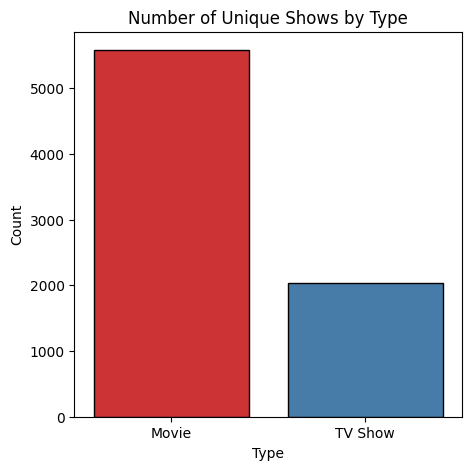

In [34]:
# Question 1a: How many unique shows are in the dataset?
# Question 1b: What is the distribution of show types (e.g., Movies vs. TV Shows)?

num_unique_shows = data['show_id'].nunique()
print(f'The number of unique shows in the Netflix dataset is: {num_unique_shows}')

# Movies and TV Shows Count ------------------------------------------------------------------------------

agg_para = {"show_id": "nunique"}
type_distribution = (data
                     .groupby(["type"])
                     .agg(agg_para)
                     .reset_index()
                     .rename(columns={"show_id": "count"})
                    )
type_distribution['percentage'] = ((type_distribution['count'] / num_unique_shows) * 100).round(1)

display(type_distribution)

# Plot ---------------------------------------------------------------------------------------------------

fig = plt.subplots(figsize=(5, 5))
# sns.set_palette(sns.color_palette("deep", 2))
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.barplot(x='type',
            y='count',
            data=type_distribution,
            hue='type',
            dodge=False,
            palette = "Set1",
            legend=False,
            edgecolor = "black"
            )

plt.title('Number of Unique Shows by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


#### 2. **Titles and Directors:**
   - What are the most common words in show titles?
   - Which directors have directed the most shows?

In [35]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
# Combine all show titles into a single string
all_titles = ' '.join(data['title'].unique().astype(str))

# Tokenize the combined string
tokens = word_tokenize(all_titles)

# Remove punctuation and convert to lowercase
table = str.maketrans('', '', string.punctuation)
tokens = [w.translate(table).lower() for w in tokens]

# Filter out stop words
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]

# Count the occurrences of each word
word_counts = Counter(tokens)

# Get the most common words and their counts
most_common_words = word_counts.most_common(12)

# Filter out ": 1952" and "2: 126" from the most common words list
most_common_words = [print(f"{word}: {count}") for word, count in most_common_words if word != '' and word != '2']

love: 153
christmas: 77
movie: 71
man: 70
world: 65
life: 61
story: 59
time: 53
one: 52
last: 51


In [48]:
# Which directors have directed the most Movies?

movies_data = data[data['type'] == 'Movie']

print("Directors with the most movies directed:\n")
(movies_data
 .groupby('director')['show_id']
 .nunique()
 .sort_values(ascending=False)
 .head(10)
 .reset_index(drop=False)
 )

Directors with the most movies directed:



,director,show_id
0,Jan Suter,22
1,Raúl Campos,20
2,Robert Rodriguez,20
3,Rajiv Chilaka,19
4,Steve Brill,18
5,Martin Scorsese,18
6,Anurag Kashyap,17
7,Jay Karas,15
8,Marcus Raboy,15
9,Peter Spirer,15


In [46]:
# Which directors have directed the most TV Shows?

tv_data = data[data['type'] == 'TV Show']

print("Directors with the most TV Show directed:\n")
(tv_data
 .groupby('director')['show_id'].nunique()
 .sort_values(ascending=False)
 .head(10)
 .reset_index(drop=False)
 )

Directors with the most TV Show directed:



,director,show_id
0,Danny Cannon,326
1,Thomas Astruc,251
2,Noam Murro,247
3,Kenny Ortega,240
4,Yasuhiro Irie,174
5,Shin Won-ho,155
6,Rob Seidenglanz,91
7,Michael Simon,81
8,Ken Burns,79
9,Damien Chazelle,72


In [88]:
# Create the pivot table
d = pd.pivot_table(data,
                   index="director",
                   columns="type",
                   values="show_id",
                   aggfunc="nunique"
                       ).rename(columns={"TV Show": "TV_Show"})
d["Total_Shows"] = d["Movie"] + d["TV_Show"]
#---------------------------------------

(d
 .query("Movie > 0 and TV_Show > 0")
 .sort_values(by="Total_Shows", ascending=False)
)[:10]

type,Movie,TV_Show,Total_Shows
director,,,
Thomas Astruc,1.0,251.0,252.0
Noam Murro,1.0,247.0,248.0
Michael Simon,5.0,81.0,86.0
Ken Burns,2.0,79.0,81.0
Kyran Kelly,1.0,59.0,60.0
Eli Roth,2.0,55.0,57.0
Manolo Caro,2.0,51.0,53.0
Mateo Gil,1.0,43.0,44.0
Jani Lachauer,1.0,40.0,41.0


####3. **Cast:**
   - Which actors appear most frequently in the dataset?


In [136]:
# Filter the data for movies only
movies_data = data[data['type'] == 'Movie']

# Print the actors who appear most frequently in the dataset
print("Actors appearing most frequently in movies:\n")

# Group by 'cast', count unique 'show_id', sort by the counts in descending order, and get the top 10
(movies_data
  .groupby('cast')['show_id']
  .nunique()
  .sort_values(ascending=False)
  .head(10)
  .reset_index()
)

Actors appearing most frequently in movies:



,cast,show_id
0,Anupam Kher,42
1,Shah Rukh Khan,35
2,Naseeruddin Shah,32
3,Om Puri,30
4,Akshay Kumar,30
5,Julie Tejwani,28
6,Amitabh Bachchan,28
7,Paresh Rawal,28
8,Boman Irani,27
9,Rupa Bhimani,27


In [137]:
# Filter the data for TV shows only
tv_shows_data = data[data['type'] == 'TV Show']

# Print the actors who appear most frequently in the dataset
print("Actors appearing most frequently in TV shows:\n")

# Group by 'cast', count unique 'show_id', sort by the counts in descending order, and get the top 10
(tv_shows_data
  .groupby('cast')['show_id']
  .nunique()
  .sort_values(ascending=False)
  .head(10)
  .reset_index()
)


Actors appearing most frequently in TV shows:



,cast,show_id
0,Takahiro Sakurai,22
1,Yuki Kaji,18
2,Daisuke Ono,17
3,Junichi Suwabe,16
4,Yoshimasa Hosoya,15
5,Yuichi Nakamura,15
6,Ai Kayano,15
7,David Attenborough,14
8,Jun Fukuyama,14
9,Kana Hanazawa,13


In [134]:
# Create the pivot table
d = pd.pivot_table(data,
                   index="cast",
                   columns="type",
                   values="show_id",
                   aggfunc="nunique"
                       ).rename(columns={"TV Show": "TV_Show"})
d["Total_Shows"] = d["Movie"] + d["TV_Show"]
#---------------------------------------

(d
 .query("Movie > 5 and TV_Show > 5")
 .sort_values(by="Total_Shows", ascending=False)
)[:10]

type,Movie,TV_Show,Total_Shows
cast,,,
Takahiro Sakurai,7.0,22.0,29.0
Yuki Kaji,10.0,18.0,28.0
Fred Tatasciore,17.0,6.0,23.0
Tara Strong,15.0,8.0,23.0
Vincent Tong,11.0,11.0,22.0
Andrea Libman,14.0,6.0,20.0
David Attenborough,6.0,14.0,20.0
Ashleigh Ball,9.0,10.0,19.0
Mamoru Miyano,6.0,13.0,19.0


#### 4. **Genres and Categories:**
   - What are the most common genres/categories listed in the dataset?
   - How many shows belong to multiple genres?

In [153]:
# data

In [151]:
# Filter the data for movies only
movies_data = data[data['type'] == 'Movie']

# Print the most common genres/categories listed in the dataset
print("Most common genres/categories listed in the dataset:\n")

# Group by 'listed_in', count unique 'show_id', sort by the counts in descending order, and get the top 10
(movies_data
  .groupby('listed_in')['show_id'].nunique()
  .sort_values(ascending=False)
  .head(10)
  .reset_index()
)

Most common genres/categories listed in the dataset:



,listed_in,show_id
0,International Movies,2554
1,Dramas,2408
2,Comedies,1653
3,Action & Adventure,852
4,Independent Movies,750
5,Romantic Movies,608
6,Children & Family Movies,601
7,Thrillers,576
8,Documentaries,424
9,Horror Movies,354


In [152]:
# Filter the data for TV shows only
tv_shows_data = data[data['type'] == 'TV Show']


print("Most common genres/categories listed in the dataset:\n")

# Group by 'listed_in', count unique 'show_id', sort by the counts in descending order, and get the top 10
(tv_shows_data
  .groupby('listed_in')['show_id']
  .nunique()
  .sort_values(ascending=False)
  .head(10)
  .reset_index()
  )


Most common genres/categories listed in the dataset:



,listed_in,show_id
0,International TV Shows,1063
1,TV Dramas,664
2,TV Comedies,485
3,Crime TV Shows,364
4,Kids' TV,341
5,Romantic TV Shows,301
6,British TV Shows,200
7,Docuseries,164
8,TV Action & Adventure,153
9,Anime Series,150


#### 5. **Country:**
   - Which countries produce the most shows in the dataset?
   - How does the distribution of show types vary by country?

In [155]:
# Filter the data for movies only
movies_data = data[data['type'] == 'Movie']

print("Most common countries listed in movies:\n")
# Group by 'country', count unique 'show_id', sort by the counts in descending order, and get the top 10
most_common_countries_movies = (movies_data
  .groupby('country')['show_id'].nunique()
  .sort_values(ascending=False)
  .head(10)
  .reset_index()
)

Most common genres/categories listed in the dataset:



,country,show_id
0,United States,2580
1,India,1027
2,United Kingdom,501
3,Canada,302
4,France,298
5,Germany,174
6,Spain,161
7,Japan,132
8,Nigeria,127
9,Egypt,117


In [158]:
# Filter the data for TV shows only
tv_shows_data = data[data['type'] == 'TV Show']

print("Most common countries listed in TV shows:\n")
# Group by 'country', count unique 'show_id', sort by the counts in descending order, and get the top 10
(tv_shows_data
  .groupby('country')['show_id'].nunique()
  .sort_values(ascending=False)
  .head(10)
  .reset_index()
)



Most common countries listed in TV shows:



,country,show_id
0,United States,788
1,United Kingdom,232
2,Japan,194
3,South Korea,169
4,Canada,119
5,France,77
6,Taiwan,72
7,India,67
8,Australia,58
9,Mexico,55


In [159]:
# Create the pivot table
d = pd.pivot_table(data,
                   index="country",
                   columns="type",
                   values="show_id",
                   aggfunc="nunique"
                       ).rename(columns={"TV Show": "TV_Show"})
d["Total_Shows"] = d["Movie"] + d["TV_Show"]
#---------------------------------------

(d
 .query("Movie > 0 and TV_Show > 0")
 .sort_values(by="Total_Shows", ascending=False)
)[:10]

type,Movie,TV_Show,Total_Shows
country,,,
United States,2580.0,788.0,3368.0
India,1027.0,67.0,1094.0
United Kingdom,501.0,232.0,733.0
Canada,302.0,119.0,421.0
France,298.0,77.0,375.0
Japan,132.0,194.0,326.0
South Korea,61.0,169.0,230.0
Spain,161.0,54.0,215.0
Germany,174.0,39.0,213.0


In [ ]:
break

In [ ]:
break--

**Mode Imputation on Director Feature**

In [ ]:
# # Drop rows where 'director' is null
# filtered_df = merged_df.dropna(subset=['director'])

# # Define a function to sort directors by frequency
# def sort_directors_by_frequency(directors):
#     if directors.empty:
#         return None, None
#     director_count = directors.value_counts()  # Count occurrences of each director
#     sorted_directors = director_count.index.tolist()  # Sort directors by frequency
#     return ', '.join(sorted_directors), sorted_directors[0]

# # Group by and perform string aggregation with sorted directors
# grouped_df = (filtered_df
#               .groupby(["listed_in", "country", "type"])["director"]
#               .apply(sort_directors_by_frequency)
#               .apply(pd.Series)
#               )

# # Rename columns
# grouped_df.columns = ['sorted_directors', 'first_director']

# # Reset index
# grouped_df = grouped_df.reset_index()
# grouped_df[:10]

In [ ]:
# # Create a dictionary mapping group keys to first director names
# group_first_directors = {}
# for index, row in grouped_df.iterrows():
#     key = (row["listed_in"], row["country"], row["type"])
#     group_first_directors[key] = row["first_director"]

# # Fill missing values in merged_df["director"] based on the mapping
# for index, row in merged_df.iterrows():
#     key = (row["listed_in"], row["country"], row["type"])
#     if pd.isna(row["director"]):
#         merged_df.at[index, "director"] = group_first_directors.get(key, row["director"])

# merged_df[:5]

In [ ]:
# x1 = round(len(merged_df[merged_df["director"].isna()])/len(merged_df)*100,2)
# x2 = round(len(merged_df[merged_df["country"].isna()])/len(merged_df)*100,2)
# y = round(len(merged_df[merged_df["director"].isna() & merged_df["country"].isna()])/len(merged_df)*100,2)
# x1,x2,y

In [ ]:
import

**Mode Imputation on Country Feature**

In [ ]:
# Drop rows where 'country' is null
filtered_df_country = merged_df.dropna(subset=['country'])

# Define a function to sort countries by frequency
def sort_countries_by_frequency(countries):
    if countries.empty:
        return None, None
    country_count = countries.value_counts()  # Count occurrences of each country
    sorted_countries = country_count.index.tolist()  # Sort countries by frequency
    return ', '.join(sorted_countries), sorted_countries[0]

# Group by and perform string aggregation with sorted countries
grouped_df_country = (filtered_df_country
                      .groupby(["listed_in", "type"
                      , "cast"
                                ]
                               )["country"]
                      .apply(sort_countries_by_frequency)
                      .apply(pd.Series)
                      )

# Rename columns
grouped_df_country.columns = ['sorted_countries', 'first_country']

# Reset index
grouped_df_country = grouped_df_country.reset_index()
grouped_df_country[:10]


In [ ]:
# Create a dictionary mapping group keys to first country names
group_first_countries = {}
for index, row in grouped_df_country.iterrows():
    key = (row["listed_in"], row["type"]
           , row["cast"]
           )
    group_first_countries[key] = row["first_country"]

# Fill missing values in merged_df["country"] based on the mapping
for index, row in merged_df.iterrows():
    key = (row["listed_in"], row["type"]
            , row["cast"]
           )
    if pd.isna(row["country"]):
        merged_df.at[index, "country"] = group_first_countries.get(key, row["country"])

merged_df[:5]


In [ ]:
x1 = round(len(merged_df[merged_df["director"].isna()])/len(merged_df)*100,2)
x2 = round(len(merged_df[merged_df["country"].isna()])/len(merged_df)*100,2)
y = round(len(merged_df[merged_df["director"].isna() & merged_df["country"].isna()])/len(merged_df)*100,2)
x1,x2,y

In [ ]:
d = data_quality_statistics(merged_df)
d[d["Percentage of NaN"] > 0].reset_index(drop=True)

In [ ]:
merged_df[merged_df["date_added"].isna()]